# Import Libs

In [ ]:
# import modules
import pandas as pd
import numpy as np
from pylab import *
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import sys
import os.path

if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))

if not shutil.which("ipopt"):
    # here is the IPOPT zip file
    !gdown 10XRvLZqrpSNiXVAN-pipU52BVRwoGcNQ
    !unzip -o -q ipopt-linux64_dw
    assert(shutil.which("ipopt") or os.path.isfile("ipopt"))

from pyomo.environ import *

SOLVER = 'ipopt'
EXECUTABLE = '/content/ipopt'
ipopt_executable = '/content/ipopt'

# some stock-specific packages
!pip install yahoo_fin
!pip install requests_html
import yahoo_fin.stock_info as si

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 67.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 4.9 MB/s eta 0:00:00
Downloading...
From: https://drive.google.com/uc?id=10XRvLZqrpSNiXVAN-pipU52BVRwoGcNQ
To: /content/ipopt-linux64_dw.zip
100% 1.82M/1.82M [00:00<00:00, 142MB/s]
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.4/83.4 kB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 12.7 MB/s eta 0:00:00
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1270 sha256=c78e498170e4f3bb66a3558506c0d84fd139f07bfc5f4d5db17b055fd0

In [ ]:
# Assign the ticker list that we want to scrap
#tickers_list = ['APD','ALB','BALL','LMT','RTX','EMR','TSLA','MCD','AMZN']
# pull historical price data for each stocks to match with our news score later
#dow_prices = {ticker : si.get_data(ticker,start_date = '01/01/2017',end_date='12/31/2021',interval='1d') for ticker in tickers_list}



In [ ]:
# Assign the ticker list that we want to scrap
tickers_list = ['APD', 'ALB', 'BALL', 'LMT', 'RTX', 'EMR', 'NKE', 'MCD', 'AMZN']
# pull historical price data for each stocks to match with our news score later
dow_prices = {ticker : si.get_data(ticker,start_date = '01/01/2017',end_date='12/31/2021',interval='1d') for ticker in tickers_list}
dow_prices

{'APD':                   open        high         low       close    adjclose  \
 2017-01-03  143.559998  144.729996  142.839996  143.399994  123.537323   
 2017-01-04  144.039993  144.839996  143.690002  144.649994  124.614159   
 2017-01-05  144.380005  144.419998  142.839996  143.220001  123.382256   
 2017-01-06  143.240005  144.800003  142.949997  144.360001  124.364365   
 2017-01-09  144.300003  147.589996  144.289993  146.309998  126.044258   
 ...                ...         ...         ...         ...         ...   
 2021-12-23  297.399994  300.570007  297.399994  299.480011  288.728882   
 2021-12-27  301.420013  302.359985  298.779999  302.220001  291.370575   
 2021-12-28  303.149994  304.350006  301.809998  303.989990  293.076965   
 2021-12-29  305.980011  306.160004  304.040009  305.399994  294.436340   
 2021-12-30  306.000000  306.489990  302.010010  303.890015  292.980591   
 
              volume ticker  
 2017-01-03  1402100    APD  
 2017-01-04  2012200    APD  
 

# 1 - Data Preparation and EDA


## 1.1 Data Retrieval and Cleaning

In [ ]:
prep_data = pd.DataFrame(dow_prices['APD']['adjclose']).rename(columns = {"adjclose":"APD"})

for i in tickers_list[1:]:
  prep_data[i] = pd.DataFrame(dow_prices[i]['adjclose'])

prep_data.shape


(1258, 9)

In [ ]:
prep_data.isnull().sum()

APD     0
ALB     0
BALL    0
LMT     0
RTX     0
EMR     0
NKE     0
MCD     0
AMZN    0
dtype: int64

In [ ]:
returns_df = pd.DataFrame()
for i in tickers_list:
#pct_change : Percentage change between the current and a prior element.
  returns_df[i] = prep_data[i].pct_change()
# drop the na records
returns_df.dropna(inplace=True)
returns_df

,APD,ALB,BALL,LMT,RTX,EMR,NKE,MCD,AMZN
2017-01-04,0.008717,0.030096,0.015182,0.002684,0.000632,-0.005970,0.020970,-0.001171,0.004657
2017-01-05,-0.009886,-0.003418,-0.000521,0.007835,0.004058,-0.008302,-0.000188,0.001841,0.030732
2017-01-06,0.007960,0.004646,0.004424,0.007305,0.010777,0.004631,0.016019,0.008855,0.019912
2017-01-09,0.013508,-0.003634,-0.015803,-0.000155,-0.009329,-0.003723,-0.009831,-0.002733,0.001168
2017-01-10,-0.007177,-0.006632,-0.004738,-0.006361,-0.002153,0.008898,-0.005058,-0.001495,-0.001280
...,...,...,...,...,...,...,...,...,...
2021-12-23,0.007807,0.011855,-0.000333,0.011307,0.009873,0.015689,0.001390,0.003812,0.000184
2021-12-27,0.009149,0.022817,0.021333,0.009394,0.004005,0.009750,0.011529,0.008611,-0.008178
2021-12-28,0.005856,-0.001287,0.025892,0.009907,0.009151,0.007812,-0.006922,-0.001342,0.005844
2021-12-29,0.004638,-0.001160,0.009862,0.001470,-0.001511,0.000646,0.014181,0.002277,-0.008555


## 1.2 Time Series Visualizations






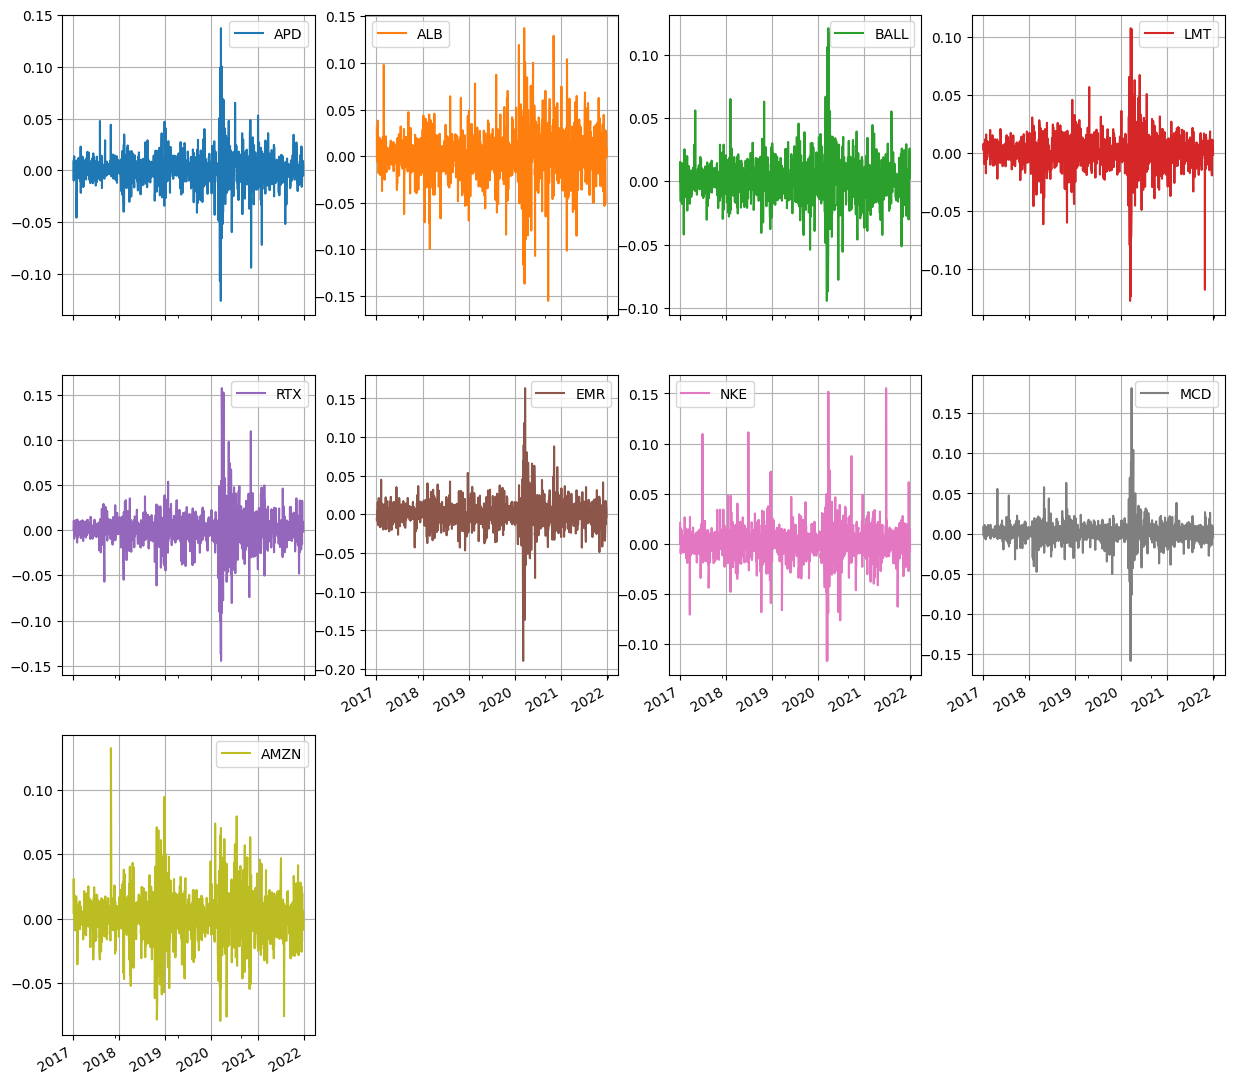

In [ ]:
returns_df.plot(subplots=True,
        grid=True,
        layout=(3,4),
         figsize=(15,15))
plt.show()

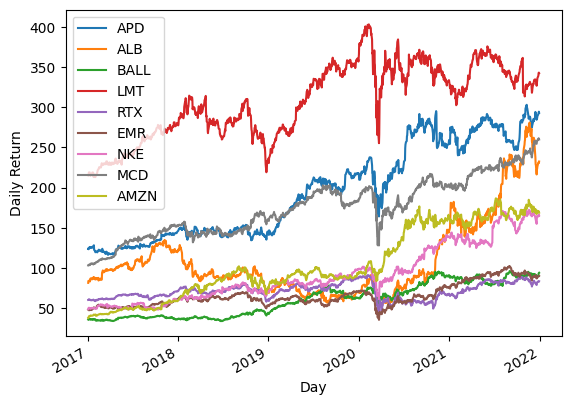

In [ ]:
# Visualization of daily return of all the stocks
prep_data.plot()
plt.xlabel('Day')
plt.ylabel('Daily Return')
plt.show()

### 1.2.1 Visualization of Sector Materials
1.   APD
2.   ALB
3.   BALL



<Axes: >

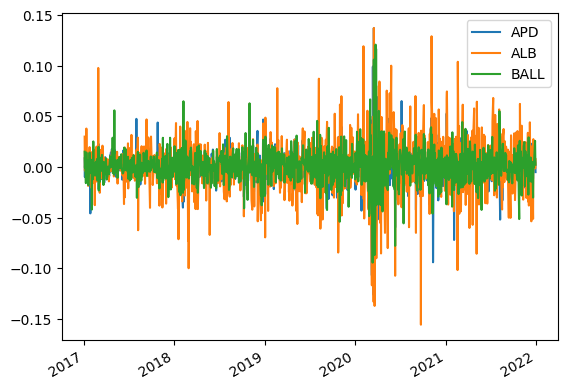

In [ ]:
returns_df.plot(y=['APD','ALB','BALL'])

### 1.2.2 Visualization of Sector Industrial

<Axes: >

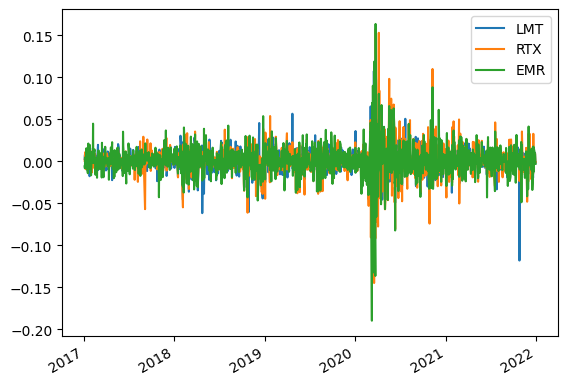

In [ ]:
returns_df.plot(y=['LMT', 'RTX', 'EMR'])


### 1.2.3 Visualization of Sector Consumer Discretionary

<Axes: >

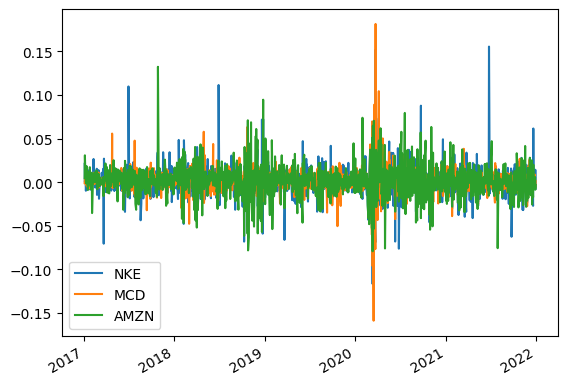

In [ ]:
returns_df.plot(y=['NKE', 'MCD', 'AMZN'])

In [ ]:
cov_matrix = returns_df.cov()
cov_matrix
cov_matrix.style.background_gradient(cmap='coolwarm')

,APD,ALB,BALL,LMT,RTX,EMR,NKE,MCD,AMZN
APD,0.000263,0.000211,0.000136,0.000125,0.000167,0.000181,0.000137,0.000115,0.000103
ALB,0.000211,0.000701,0.000154,0.000149,0.000239,0.000256,0.000179,0.000114,0.000139
BALL,0.000136,0.000154,0.000263,0.000112,0.000127,0.000107,0.000120,0.000101,0.000087
LMT,0.000125,0.000149,0.000112,0.000243,0.000174,0.000140,0.000124,0.000098,0.000082
RTX,0.000167,0.000239,0.000127,0.000174,0.000393,0.000271,0.000188,0.000163,0.000092
EMR,0.000181,0.000256,0.000107,0.000140,0.000271,0.000378,0.000189,0.000149,0.000100
NKE,0.000137,0.000179,0.000120,0.000124,0.000188,0.000189,0.000339,0.000127,0.000117
MCD,0.000115,0.000114,0.000101,0.000098,0.000163,0.000149,0.000127,0.000212,0.000077
AMZN,0.000103,0.000139,0.000087,0.000082,0.000092,0.000100,0.000117,0.000077,0.000344


In [ ]:
corr_matrix = returns_df.corr()
corr_matrix
corr_matrix.style.background_gradient(cmap='coolwarm')

,APD,ALB,BALL,LMT,RTX,EMR,NKE,MCD,AMZN
APD,1.000000,0.491157,0.516064,0.493078,0.520283,0.576422,0.459491,0.487522,0.342648
ALB,0.491157,1.000000,0.357841,0.360296,0.455531,0.498094,0.366596,0.295862,0.283168
BALL,0.516064,0.357841,1.000000,0.441460,0.394778,0.339191,0.400899,0.428908,0.289303
LMT,0.493078,0.360296,0.441460,1.000000,0.562914,0.461193,0.430692,0.434212,0.282057
RTX,0.520283,0.455531,0.394778,0.562914,1.000000,0.703704,0.515707,0.564682,0.249424
EMR,0.576422,0.498094,0.339191,0.461193,0.703704,1.000000,0.528059,0.528760,0.278426
NKE,0.459491,0.366596,0.400899,0.430692,0.515707,0.528059,1.000000,0.473296,0.342127
MCD,0.487522,0.295862,0.428908,0.434212,0.564682,0.528760,0.473296,1.000000,0.285755
AMZN,0.342648,0.283168,0.289303,0.282057,0.249424,0.278426,0.342127,0.285755,1.000000


In [ ]:
df=returns_df.copy()

In [ ]:
# creating covariance table on stock return dataframe
df_cov = df.cov()
print('Covariance Matrix:')
print(df_cov)
print('\n') # return/blank line

# create the average of each stock
# these are the objective function COEFFICIENTS!
df_return = df.mean()
print('Average Return:')
print(df_return)

Covariance Matrix:
           APD       ALB      BALL       LMT       RTX       EMR       NKE  \
APD   0.000263  0.000211  0.000136  0.000125  0.000167  0.000181  0.000137   
ALB   0.000211  0.000701  0.000154  0.000149  0.000239  0.000256  0.000179   
BALL  0.000136  0.000154  0.000263  0.000112  0.000127  0.000107  0.000120   
LMT   0.000125  0.000149  0.000112  0.000243  0.000174  0.000140  0.000124   
RTX   0.000167  0.000239  0.000127  0.000174  0.000393  0.000271  0.000188   
EMR   0.000181  0.000256  0.000107  0.000140  0.000271  0.000378  0.000189   
NKE   0.000137  0.000179  0.000120  0.000124  0.000188  0.000189  0.000339   
MCD   0.000115  0.000114  0.000101  0.000098  0.000163  0.000149  0.000127   
AMZN  0.000103  0.000139  0.000087  0.000082  0.000092  0.000100  0.000117   

           MCD      AMZN  
APD   0.000115  0.000103  
ALB   0.000114  0.000139  
BALL  0.000101  0.000087  
LMT   0.000098  0.000082  
RTX   0.000163  0.000092  
EMR   0.000149  0.000100  
NKE   0.000

In [ ]:
df_cov

,APD,ALB,BALL,LMT,RTX,EMR,NKE,MCD,AMZN
APD,0.000263,0.000211,0.000136,0.000125,0.000167,0.000181,0.000137,0.000115,0.000103
ALB,0.000211,0.000701,0.000154,0.000149,0.000239,0.000256,0.000179,0.000114,0.000139
BALL,0.000136,0.000154,0.000263,0.000112,0.000127,0.000107,0.000120,0.000101,0.000087
LMT,0.000125,0.000149,0.000112,0.000243,0.000174,0.000140,0.000124,0.000098,0.000082
RTX,0.000167,0.000239,0.000127,0.000174,0.000393,0.000271,0.000188,0.000163,0.000092
EMR,0.000181,0.000256,0.000107,0.000140,0.000271,0.000378,0.000189,0.000149,0.000100
NKE,0.000137,0.000179,0.000120,0.000124,0.000188,0.000189,0.000339,0.000127,0.000117
MCD,0.000115,0.000114,0.000101,0.000098,0.000163,0.000149,0.000127,0.000212,0.000077
AMZN,0.000103,0.000139,0.000087,0.000082,0.000092,0.000100,0.000117,0.000077,0.000344


## 1.3 - Discussion of the Plots

# Material Sector: (APD), (ALB), (BALL)
The Materials sector experienced significant growth during the period, especially from 2017 to 2019, but experienced some volatility after the 2020 due to supply chain disruptions and rising inflation concerns. Air Products and Chemicals, Inc. (APD) had a relatively stable return from 2017 to 2019, fluctuating in a narrow range of +0.05 and -0.05. However, in 2020, the return ranged between +0.14 and -0.14, likely due to the impact of the COVID-19 pandemic on the global economy. APD started to recover after 2020, with returns ranging between +0.05 and -0.08 until the end of 2021, where the range narrowed to +0.03 and -0.01.
Albemarle Corporation (ALB) had a similar return pattern as APD, with fluctuating returns ranging between +0.10 and -0.10 from 2017 to 2019. In 2020, the return ranged between +0.13 and -0.15, likely due to the impact of the pandemic on the lithium industry. ALB started to recover slowly after 2020, with returns ranging between +0.10 and -0.05 until the end of 2021. Ball Corporation (BLL) had a more stable return pattern than APD and ALB from 2017 to 2019, with returns fluctuating in a range of +0.06 and -0.04. In 2020, the return ranged between +0.12 and -0.12, likely due to the impact of the pandemic on the packaging industry. BLL started to recover after 2020, with returns ranging between +0.05 and -0.05 until the end of 2021.

## Industrial Sector: (LMT), (RTX), (EMR)
The portfolio of the Industrial sector consisted of three stocks: LMT, RTX, and EMR. Overall, the portfolio had a slight fluctuation in returns, with most of the stocks' returns ranging between +0.03 and -0.05 throughout the period from January 1, 2017, to December 31, 2021. However, in 2020, the returns of all three stocks were more volatile than the other years.
LMT had a relatively stable return throughout the whole period, with a slight fluctuation ranging between +0.03 and -0.03. However, in 2020, LMT's returns were more volatile, ranging between +0.11 and -0.12.
RTX's returns were also relatively stable throughout the period, with a slight fluctuation ranging between +0.03 and -0.05. However, like the other stocks in the portfolio, RTX's returns were more volatile in 2020, ranging between +0.15 and -0.15.
EMR's returns had a slightly higher range than the other stocks in the portfolio, fluctuating between +0.05 and -0.04. In 2020, EMR's returns were the most volatile of the three, ranging between +0.16 and -0.19.
Overall, the portfolio had a relatively stable performance with only minor fluctuations in returns, except for the year 2020 where all stocks experienced a higher level of volatility due to the impact of the COVID-19 pandemic.

##Consumer Discretionary sector: Nike (NKE), McDonald's (MCD), and Amazon (AMZN)
NKE had a positive performance overall during the period, with the return ranging between +0.05 and +0.08 from 2017 to the end of 2019. In 2020, the return ranged between +0.15 and -0.10 due to the pandemic impact.
MCD had a more stable performance during the period, with the return ranging between +0.05 and -0.04 from 2017 to the end of 2019. In 2020, the return ranged between +0.18 and -0.15 due to the pandemic impact. In 2021, the return ranged between +0.03 and -0.03, ending the period with a positive return.
AMZN had a highly volatile performance during the analyzed period, with significant fluctuations in return. From 2017 to the end of 2019, the returns ranged between +0.10 and -0.05. In 2020, however, the returns ranged between +0.03 and -0.03. AMZN was one of the major beneficiaries of the pandemic, as more people turned to online shopping, which drove the stock price up significantly. In 2021, the returns ranged between +0.05 and -0.05.

# 2 - Optimization Model



## 2.1 Model execution

In [ ]:
from pyomo.environ import *
m = ConcreteModel()

# defining variables


m.APD = Var(within=NonNegativeReals, bounds=(0,1))
m.ALB = Var(within=NonNegativeReals, bounds=(0,1))
m.BALL = Var(within=NonNegativeReals, bounds=(0,1))
m.LMT = Var(within=NonNegativeReals, bounds=(0,1))
m.RTX = Var(within=NonNegativeReals, bounds=(0,1))
m.EMR = Var(within=NonNegativeReals, bounds=(0,1))
m.NKE = Var(within=NonNegativeReals, bounds=(0,1))
m.MCD = Var(within=NonNegativeReals, bounds=(0,1))
m.AMZN = Var(within=NonNegativeReals, bounds=(0,1))


In [ ]:
# declare objective

m.objective = Objective(expr =
                        m.APD*df_return[0] +
                        m.ALB*df_return[1] +
                        m.BALL*df_return[2] +
                        m.LMT*df_return[3] +
                        m.RTX* df_return[4]+
                        m.EMR*df_return[5] +
                        m.NKE*df_return[6] +
                        m.MCD*df_return[7] +
                        m.AMZN*df_return[8],
                        sense=maximize) # yes, we want to MAX our returns!

# declare constraints
# 1. Sum of all proportions = 1
m.sum_proportions = Constraint(expr = m.APD+m.ALB+m.BALL+m.LMT+m.RTX+m.EMR+m.NKE+m.MCD+m.AMZN == 1)

# 3. Set maximum risk: WE ARE INCLUDING THIS CONSTRAINT NOW FOR TECHNICAL REASONS (see below), YOU CAN (and should!) IGNORE IT FOR NOW!
m.total_risk = Constraint(expr = m.APD+m.ALB+m.BALL+m.LMT+m.RTX+m.EMR+m.NKE+m.MCD+m.AMZN >= 0.0)


In [ ]:
# creating calculations table for calculate the risk
# 3. Calculate risk
def calc_risk(m):
  variables = m.APD,m.ALB,m.BALL,m.LMT,m.RTX,m.EMR,m.NKE,m.MCD,m.AMZN
  tickers = ['APD','ALB','BALL','LMT','RTX','EMR','NKE','MCD','AMZN']
  risk_exp = 0
  for i in range(len(variables)):
    for j in range(len(variables)):
      risk_exp += variables[i]*df_cov.at[tickers[i],tickers[j]]*variables[j]
  return risk_exp

# We are going to use this expression to compute the risk
expr_risk = calc_risk(m)

# 3. Max risk
max_risk = 0.000425
# Sequence of risk levels
risk_limits = np.arange(0.000155, max_risk, 0.0000025) # take tiny steps
risk_limits

array([0.000155 , 0.0001575, 0.00016  , 0.0001625, 0.000165 , 0.0001675,
       0.00017  , 0.0001725, 0.000175 , 0.0001775, 0.00018  , 0.0001825,
       0.000185 , 0.0001875, 0.00019  , 0.0001925, 0.000195 , 0.0001975,
       0.0002   , 0.0002025, 0.000205 , 0.0002075, 0.00021  , 0.0002125,
       0.000215 , 0.0002175, 0.00022  , 0.0002225, 0.000225 , 0.0002275,
       0.00023  , 0.0002325, 0.000235 , 0.0002375, 0.00024  , 0.0002425,
       0.000245 , 0.0002475, 0.00025  , 0.0002525, 0.000255 , 0.0002575,
       0.00026  , 0.0002625, 0.000265 , 0.0002675, 0.00027  , 0.0002725,
       0.000275 , 0.0002775, 0.00028  , 0.0002825, 0.000285 , 0.0002875,
       0.00029  , 0.0002925, 0.000295 , 0.0002975, 0.0003   , 0.0003025,
       0.000305 , 0.0003075, 0.00031  , 0.0003125, 0.000315 , 0.0003175,
       0.00032  , 0.0003225, 0.000325 , 0.0003275, 0.00033  , 0.0003325,
       0.000335 , 0.0003375, 0.00034  , 0.0003425, 0.000345 , 0.0003475,
       0.00035  , 0.0003525, 0.000355 , 0.0003575, 

In [ ]:
np.count_nonzero(risk_limits)

108

In [ ]:
from pyomo.opt import SolverStatus, TerminationCondition

# updating risk contraint for each limit and then solving the problem
param_analysis = {} # key=risk, value =stock allocations
returns = {} # key=risk, value = return
for r in risk_limits:
  # Remove constraint to avoid error messages
  m.del_component(m.total_risk)
  m.total_risk = Constraint(expr = expr_risk <= r)
  # run solver
  result = SolverFactory('ipopt', executable=ipopt_executable).solve(m)

  # If solution is not feasible, ignore this run
  if result.solver.termination_condition == TerminationCondition.infeasible:
    continue

  result = result.write()

  # store our allocation proportions
  param_analysis[r] = [m.APD(),m.ALB(),m.BALL(),m.LMT(),m.RTX(),m.EMR(),m.NKE(),m.MCD(),m.AMZN()]
  # store our returns
  returns[r] =  m.APD()*df_return[0] + m.ALB()*df_return[1] + m.BALL()*df_return[2] +m.LMT()*df_return[3] + m.RTX()* df_return[4]+m.EMR()*df_return[5] + m.NKE()*df_return[6] + m.MCD()*df_return[7]+ m.AMZN()*df_return[8]


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 2
  Number of variables: 9
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: Ipopt 3.12.13\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.013996362686157227
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0
# ====

## 2.2 Plot with allocation of the stocks

<Figure size 144000x160000 with 0 Axes>

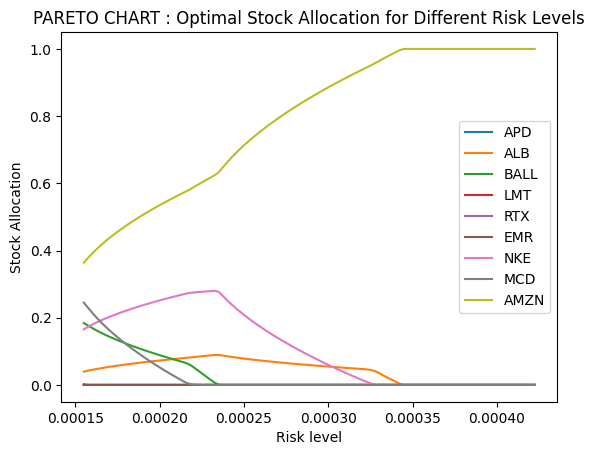

In [ ]:
# # generating the dataframe for proportions of the portfolio for each risk limit
from matplotlib.pyplot import figure
figure(figsize=(1800, 2000), dpi=80)
param_analysis = pd.DataFrame.from_dict(param_analysis, orient='index')
param_analysis.columns = ['APD','ALB','BALL','LMT','RTX','EMR','NKE','MCD','AMZN']
param_analysis.plot()
plt.title('PARETO CHART : Optimal Stock Allocation for Different Risk Levels')
plt.xlabel('Risk level')
plt.ylabel('Stock Allocation')
plt.show()

In [ ]:
# subset
risk = list(returns.keys())
print(risk)
reward = list(returns.values())
print(reward)

[0.000155, 0.0001575, 0.00016, 0.00016250000000000002, 0.00016500000000000003, 0.00016750000000000003, 0.00017000000000000004, 0.00017250000000000005, 0.00017500000000000005, 0.00017750000000000006, 0.00018000000000000007, 0.00018250000000000007, 0.00018500000000000008, 0.00018750000000000009, 0.0001900000000000001, 0.0001925000000000001, 0.0001950000000000001, 0.0001975000000000001, 0.00020000000000000012, 0.00020250000000000012, 0.00020500000000000013, 0.00020750000000000014, 0.00021000000000000014, 0.00021250000000000015, 0.00021500000000000016, 0.00021750000000000016, 0.00022000000000000017, 0.00022250000000000018, 0.00022500000000000018, 0.0002275000000000002, 0.0002300000000000002, 0.0002325000000000002, 0.0002350000000000002, 0.00023750000000000022, 0.00024000000000000022, 0.00024250000000000023, 0.0002450000000000002, 0.0002475000000000002, 0.0002500000000000002, 0.00025250000000000023, 0.00025500000000000024, 0.00025750000000000024, 0.00026000000000000025, 0.000262500000000000

## 2.3 Plot with efficient frontier

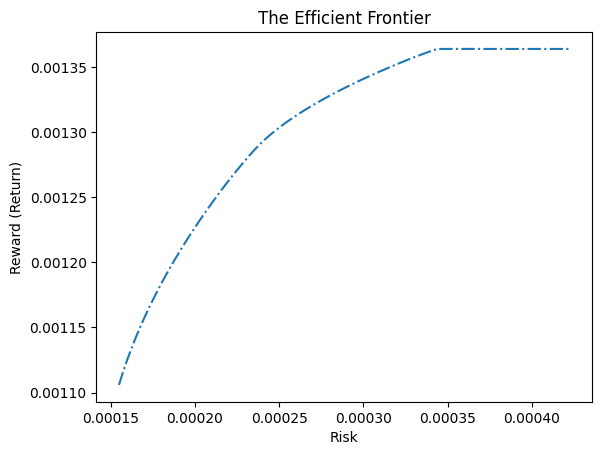

In [ ]:

from pylab import *
plot(risk, reward, '-.')
title('The Efficient Frontier')
xlabel('Risk')
ylabel('Reward (Return)')
plt.show()

In [ ]:
param_analysis.tail(60)

,APD,ALB,BALL,LMT,RTX,EMR,NKE,MCD,AMZN
0.000275,0.000009,0.065119,0.000016,0.000004,0.000004,0.000006,0.125125,0.000012,0.809704
0.000278,0.000009,0.063977,0.000015,0.000004,0.000004,0.000006,0.117982,0.000012,0.817990
0.000280,0.000009,0.062860,0.000015,0.000004,0.000004,0.000006,0.110996,0.000012,0.826094
0.000283,0.000009,0.061766,0.000015,0.000004,0.000004,0.000006,0.104155,0.000012,0.834029
0.000285,0.000009,0.060695,0.000014,0.000004,0.000004,0.000006,0.097453,0.000011,0.841804
0.000288,0.000009,0.059643,0.000014,0.000004,0.000004,0.000006,0.090880,0.000011,0.849428
0.000290,0.000009,0.058612,0.000014,0.000004,0.000004,0.000006,0.084429,0.000011,0.856911
0.000293,0.000009,0.057597,0.000014,0.000004,0.000004,0.000006,0.078095,0.000011,0.864260
0.000295,0.000009,0.056600,0.000014,0.000004,0.000004,0.000006,0.071870,0.000011,0.871482
0.000298,0.000009,0.055619,0.000014,0.000004,0.000004,0.000006,0.065752,0.000011,0.878582


## 2.4 Portfolio selection

As we can see from the Stock allocation graph, we can select three stocks out of 9, starting from a risk level of 0.00024 up to 0.00033, after which the portfolio allocation goes down to two stocks. We will select the stocks at a risk level of 0.00030, at which we get a portfolio allocation of the following three stocks - AMZN, NKE and ALB

The weights of the stocks in our portfolio is obtained through the output of our model.

AMZN - 88.5% | NKE - 6% | ALB - 5.5%

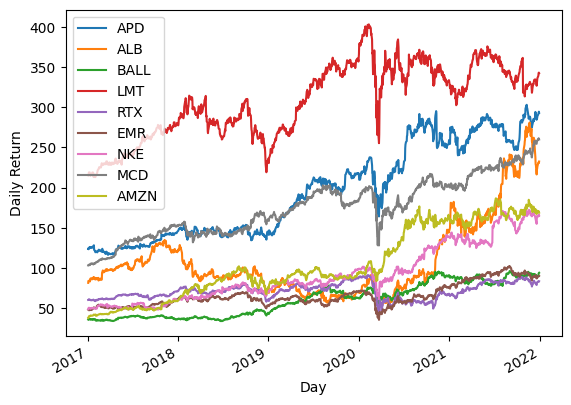

In [ ]:
# Visualization of daily return of all the stocks
prep_data.plot()
plt.xlabel('Day')
plt.ylabel('Daily Return')
plt.show()

In [ ]:
Avg_Return = pd.DataFrame(np.mean(prep_data) ,columns=["Avg_Return"])
print(Avg_Return)
Std_Dev_Return = pd.DataFrame(np.std(prep_data) ,columns=["Std_Dev_Return"])
print(Std_Dev_Return)

      Avg_Return
APD   195.259516
ALB   109.813031
BALL   60.247348
LMT   308.014515
RTX    71.123840
EMR    65.435226
NKE    91.514136
MCD   174.828372
AMZN  104.274060
      Std_Dev_Return
APD        57.793172
ALB        49.078758
BALL       20.510714
LMT        45.665713
RTX         9.337633
EMR        14.036446
NKE        34.713731
MCD        36.187318
AMZN       43.875764


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


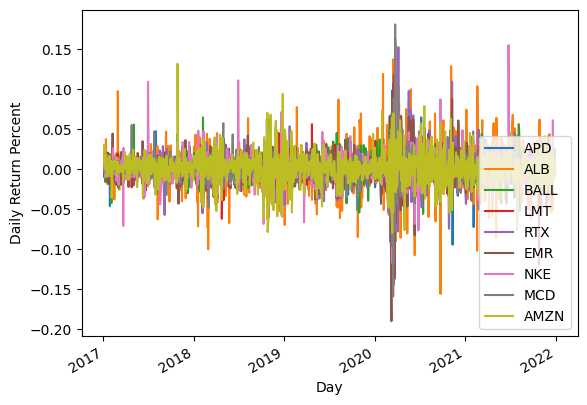

In [ ]:
# Visualization of daily return of all the stocks
returns_df.plot()
plt.xlabel('Day')
plt.ylabel('Daily Return Percent')
plt.show()





# 3 - Analysis




# 3.1 Getting data for  the selected stocks NKE, AMZN, and ABL to execute momentum trading


In [ ]:

ticker = "AMZN"
amz = si.get_data(ticker,start_date = '12/01/2021',end_date='01/01/2023',interval='1d')
day = np.arange(1, len(amz) + 1) #generate list of trading days
amz['Day'] = day
# Dropping columns I don't want to use
amz.drop(columns=['adjclose', 'volume','ticker'], inplace = True)
# Reorganizing the columns
amz = amz[['Day', 'open', 'high', 'low', 'close']]
amz.head()

ticker = "NKE"
nke = si.get_data(ticker,start_date = '12/01/2021',end_date='01/01/2023',interval='1d')
day = np.arange(1, len(nke) + 1) #generate list of trading days
nke['Day'] = day
# Dropping columns I don't want to use
nke.drop(columns=['adjclose', 'volume','ticker'], inplace = True)
# Reorganizing the columns
nke = nke[['Day', 'open', 'high', 'low', 'close']]
nke.head()


ticker = "ALB"
alb = si.get_data(ticker,start_date = '12/01/2021',end_date='01/01/2023',interval='1d')
day = np.arange(1, len(alb) + 1) #generate list of trading days
alb['Day'] = day
# Dropping columns I don't want to use
alb.drop(columns=['adjclose', 'volume','ticker'], inplace = True)
# Reorganizing the columns
alb = alb[['Day', 'open', 'high', 'low', 'close']]
print(amz.head(5))
print(nke.head(5))
print(alb.head(5))

            Day        open        high         low       close
2021-12-01    1  177.250000  177.994003  172.080002  172.186005
2021-12-02    2  173.000000  174.634995  171.187500  171.867996
2021-12-03    3  172.750000  173.493500  166.929993  169.489502
2021-12-06    4  169.649994  173.695496  166.934494  171.368500
2021-12-07    5  174.600006  177.499496  173.334503  176.164505
            Day        open        high         low       close
2021-12-01    1  170.889999  173.369995  166.679993  166.699997
2021-12-02    2  167.279999  170.550003  167.000000  170.000000
2021-12-03    3  170.619995  172.070007  166.759995  170.240005
2021-12-06    4  170.830002  171.210007  168.059998  168.910004
2021-12-07    5  171.110001  173.350006  170.399994  171.289993
            Day        open        high         low       close
2021-12-01    1  270.010010  276.000000  259.799988  259.850006
2021-12-02    2  261.000000  264.899994  255.350006  261.390015
2021-12-03    3  262.260010  267.809998 

In [ ]:
#8day 21day price difference calculation logic without the data leakage effect

amz['8-day'] = amz['close'].rolling(8).mean().shift()
amz['21-day'] = amz['close'].rolling(21).mean().shift()
amz.dropna(inplace=True)
print(amz.head(n=2))

nke['8-day'] = nke['close'].rolling(8).mean().shift()
nke['21-day'] = nke['close'].rolling(21).mean().shift()
nke.dropna(inplace=True)
print(nke.head(n=2))


alb['8-day'] = alb['close'].rolling(8).mean().shift()
alb['21-day'] = alb['close'].rolling(21).mean().shift()
alb.dropna(inplace=True)
print(alb.head(n=2))

            Day        open        high         low       close       8-day  \
2021-12-31   22  168.955994  169.350006  166.558502  166.716995  169.722187   
2022-01-03   23  167.550003  170.703506  166.160507  170.404495  169.676937   

                21-day  
2021-12-31  171.059883  
2022-01-03  170.799454  
            Day        open        high         low       close       8-day  \
2021-12-31   22  167.559998  167.720001  166.210007  166.669998  165.623751   
2022-01-03   23  167.529999  167.910004  163.309998  164.669998  166.835001   

                21-day  
2021-12-31  166.655238  
2022-01-03  166.653809  
            Day        open        high         low       close      8-day  \
2021-12-31   22  234.009995  237.130005  233.470001  233.770004  228.52375   
2022-01-03   23  236.729996  239.050003  229.399994  236.669998  230.47875   

                21-day  
2021-12-31  242.245715  
2022-01-03  241.003810  


## Plot the moving averages for the three stocks


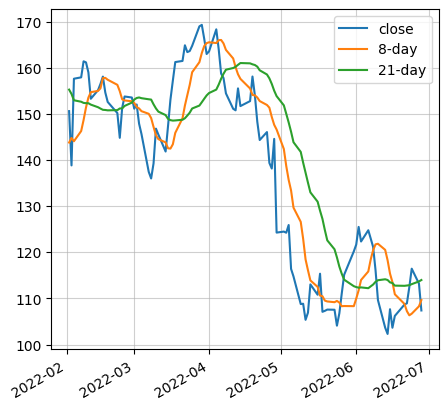

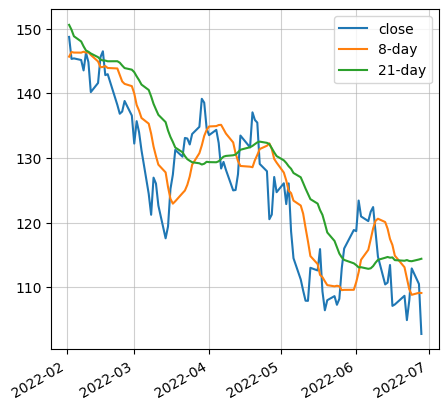

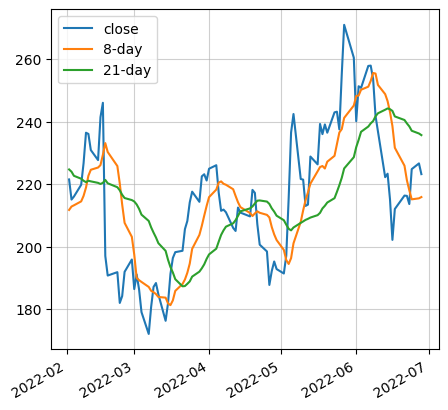

In [ ]:
amz.iloc[22:123,[4,5,6]].plot(figsize=(5,5))
plt.grid(True, alpha = .6)
plt.show()

nke.iloc[22:123,[4,5,6]].plot(figsize=(5,5))
plt.grid(True, alpha = .6)
plt.show()

alb.iloc[22:123,[4,5,6]].plot(figsize=(5,5))
plt.grid(True, alpha = .6)
plt.show()

**Buy and Hold Strategy**

you buy a stock on one day and you sell it on the last day and the returns are calculated based on the difference between the prices on first and last day of the trade. Always use log of the returns to compute continous returns


In [ ]:
amz['log_close'] = np.log(amz['close'])
amz['return'] = amz['log_close'].diff()

nke['log_close'] = np.log(nke['close'])
nke['return'] = nke['log_close'].diff()

alb['log_close'] = np.log(alb['close'])
alb['return'] = alb['log_close'].diff()


In [ ]:
#Buy and hold returns for each stock in the portfolio
print("Amazon Buy-Hold retruns: ", np.exp(np.sum(amz['return'])) -1)
print("Nike Buy-Hold retruns: ",np.exp(np.sum(nke['return'])) -1)
print("Albermale Buy-Hold retruns: ",np.exp(np.sum(alb['return'])) -1)

amz_bh_return = np.exp(np.sum(amz['return'])) -1
nike_bh_return = np.exp(np.sum(nke['return'])) -1
alb_bh_return = np.exp(np.sum(alb['return'])) -1

Amazon Buy-Hold retruns:  -0.4961521476592685
Nike Buy-Hold retruns:  -0.2979540203893021
Albermale Buy-Hold retruns:  -0.07233607115137275


#3.2 - Momentum trading strategy for each stock in the MPT portfolio

Creating a new column to flag if the 8day avg is greater than 21day average and then signalling to buy or sell based on the parity differneces


In [ ]:
amz['flag'] = np.where(amz['8-day'] > amz['21-day'], 1, 0)
amz['action'] = amz['flag'].diff()
print(amz['action'].value_counts())

nke['flag'] = np.where(nke['8-day'] > nke['21-day'], 1, 0)
nke['action'] = nke['flag'].diff()
print(nke['action'].value_counts())

alb['flag'] = np.where(alb['8-day'] > alb['21-day'], 1, 0)
alb['action'] = alb['flag'].diff()
print(alb['action'].value_counts())

 0.0    239
 1.0      6
-1.0      6
Name: action, dtype: int64
 0.0    240
 1.0      6
-1.0      5
Name: action, dtype: int64
 0.0    237
 1.0      7
-1.0      7
Name: action, dtype: int64


In [ ]:
amz[amz['action'].isin([1,-1])] ## amazon trading days

,Day,open,high,low,close,8-day,21-day,log_close,return,flag,action
2022-02-10,50,158.350006,160.716507,157.750000,159.003494,153.550375,152.327095,5.068926,-0.013655,1,1.0
2022-03-01,62,152.732498,154.098999,149.977005,151.141998,152.386061,153.116380,5.018220,-0.015891,0,-1.0
2022-03-21,76,161.121002,163.084000,159.552994,161.491501,149.054253,148.743977,5.084453,0.001493,1,1.0
2022-04-12,92,153.692505,155.098999,150.382996,150.787506,160.135246,160.224428,5.015872,-0.002216,0,-1.0
2022-06-03,128,124.199997,124.400002,121.046501,122.349998,114.007563,112.398834,4.806886,-0.025508,1,1.0
2022-06-17,138,102.800003,106.980003,102.510002,106.220001,110.911250,112.786334,4.665512,0.024396,0,-1.0
2022-07-08,151,114.599998,116.580002,113.690002,115.540001,111.183750,110.929048,4.749617,-0.006814,1,1.0
2022-08-26,186,136.550003,137.830002,130.500000,130.750000,138.166250,138.204763,4.873287,-0.048736,0,-1.0
2022-10-26,228,116.000000,119.349998,114.760002,115.660004,115.888750,115.781905,4.750655,-0.041824,1,1.0
2022-11-01,232,103.989998,104.580002,96.059998,96.790001,113.432501,114.460476,4.572544,-0.056734,0,-1.0


In [ ]:
nke[nke['action'].isin([1,-1])] ## nike trading days

,Day,open,high,low,close,8-day,21-day,log_close,return,flag,action
2022-01-03,23,167.529999,167.910004,163.309998,164.669998,166.835001,166.653809,5.103943,-0.012072,1,1.0
2022-01-10,28,150.520004,151.330002,148.779999,150.440002,164.282499,164.779047,5.013564,-0.042490,0,-1.0
2022-03-28,81,133.759995,134.860001,132.169998,134.809998,130.737501,129.168095,4.903866,0.008268,1,1.0
2022-04-13,93,125.040001,127.860001,125.040001,127.489998,129.508751,130.877143,4.848038,0.019404,0,-1.0
2022-04-26,101,126.949997,127.589996,120.480003,120.519997,132.246253,132.132858,4.791816,-0.059746,1,1.0
2022-04-27,102,121.089996,124.000000,121.089996,121.239998,131.375003,131.505239,4.797772,0.005956,0,-1.0
2022-06-03,128,120.209999,122.540001,120.000000,120.949997,114.248750,113.095714,4.795377,-0.020135,1,1.0
2022-06-21,139,108.459999,109.820000,108.040001,108.680000,113.098751,114.098572,4.688408,0.012406,0,-1.0
2022-07-22,161,111.930000,111.930000,108.750000,109.120003,106.581251,106.100477,4.692448,-0.022652,1,1.0
2022-08-26,186,113.309998,113.730003,108.230003,108.279999,113.740001,113.786191,4.684720,-0.044612,0,-1.0


In [ ]:
alb[alb['action'].isin([1,-1])] ## Albermarle trading days

,Day,open,high,low,close,8-day,21-day,log_close,return,flag,action
2022-01-11,29,227.660004,240.899994,227.149994,240.169998,234.922503,234.728572,5.481347,0.056529,1,1.0
2022-01-21,36,214.039993,219.490005,207.740005,212.750000,230.031250,231.827143,5.360118,-0.020471,0,-1.0
2022-02-10,50,233.449997,244.309998,232.149994,236.039993,222.676250,221.078570,5.464001,-0.001651,1,1.0
2022-02-24,59,172.259995,184.960007,169.929993,184.199997,213.448750,216.587141,5.216022,0.012015,0,-1.0
2022-03-21,76,199.020004,200.630005,193.000000,198.679993,188.044998,187.324762,5.291695,0.002217,1,1.0
2022-04-18,95,210.850006,213.440002,208.440002,209.669998,210.753752,212.235237,5.345535,-0.005802,0,-1.0
2022-05-09,110,238.000000,239.399994,220.770004,221.639999,207.904999,207.600476,5.401054,-0.089576,1,1.0
2022-06-15,136,225.800003,225.979996,210.880005,215.080002,243.032501,243.938572,5.371010,-0.037640,0,-1.0
2022-07-25,162,221.580002,227.789993,217.160004,227.570007,209.416252,209.184285,5.427458,0.027216,1,1.0
2022-09-08,194,277.690002,292.290009,276.980011,291.429993,272.075001,274.293334,5.674800,0.042871,0,-1.0


In [ ]:
amz['momentum_return'] = amz['flag'] * amz['return']
amz.head()

,Day,open,high,low,close,8-day,21-day,log_close,return,flag,action,momentum_return
2021-12-31,22,168.955994,169.350006,166.558502,166.716995,169.722187,171.059883,5.116298,NaN,0,NaN,NaN
2022-01-03,23,167.550003,170.703506,166.160507,170.404495,169.676937,170.799454,5.138175,0.021877,0,0.0,0.0
2022-01-04,24,170.438004,171.399994,166.349503,167.522003,169.675373,170.729763,5.121115,-0.017060,0,0.0,-0.0
2022-01-05,25,166.882996,167.126495,164.356995,164.356995,169.235998,170.636073,5.102041,-0.019074,0,0.0,-0.0
2022-01-06,26,163.450500,164.800003,161.936996,163.253998,168.397060,170.302192,5.095307,-0.006734,0,0.0,-0.0


In [ ]:
nke['momentum_return'] = nke['flag'] * nke['return']
nke.head()

,Day,open,high,low,close,8-day,21-day,log_close,return,flag,action,momentum_return
2021-12-31,22,167.559998,167.720001,166.210007,166.669998,165.623751,166.655238,5.116016,NaN,0,NaN,NaN
2022-01-03,23,167.529999,167.910004,163.309998,164.669998,166.835001,166.653809,5.103943,-0.012072,1,1.0,-0.012072
2022-01-04,24,165.880005,167.179993,165.000000,166.389999,166.590000,166.400000,5.114334,0.010391,1,0.0,0.010391
2022-01-05,25,166.490005,167.009995,162.100006,162.250000,166.708750,166.216666,5.089138,-0.025196,1,0.0,-0.025196
2022-01-06,26,162.089996,163.190002,159.059998,161.039993,166.281250,165.899523,5.081653,-0.007486,1,0.0,-0.007486


In [ ]:
alb['momentum_return'] = alb['flag'] * alb['return']
alb.head()

,Day,open,high,low,close,8-day,21-day,log_close,return,flag,action,momentum_return
2021-12-31,22,234.009995,237.130005,233.470001,233.770004,228.523750,242.245715,5.454338,NaN,0,NaN,NaN
2022-01-03,23,236.729996,239.050003,229.399994,236.669998,230.478750,241.003810,5.466667,0.012329,0,0.0,0.0
2022-01-04,24,239.020004,247.949997,238.470001,242.580002,232.043751,239.826667,5.491332,0.024665,0,0.0,0.0
2022-01-05,25,240.000000,247.429993,235.380005,235.639999,234.212502,239.403333,5.462305,-0.029026,0,0.0,-0.0
2022-01-06,26,234.000000,235.669998,227.169998,233.380005,235.180002,238.789048,5.452668,-0.009637,0,0.0,-0.0


## Comparing two strategies between Buy-hold and Momentum for the stocks in portfolio

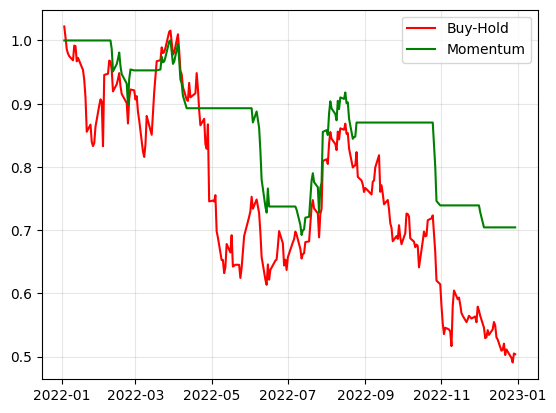

In [ ]:
plt.plot(np.exp(amz['return']).cumprod(), label='Buy-Hold', color= 'red')
plt.plot(np.exp(amz['momentum_return']).cumprod(), label='Momentum', color= 'green')
plt.legend(loc=0)
plt.grid(True, alpha=.3)
plt.show()

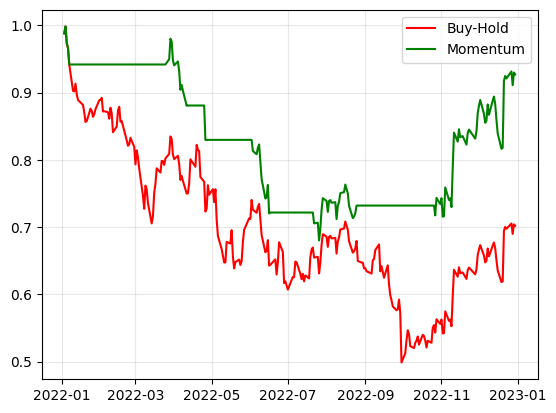

In [ ]:
plt.plot(np.exp(nke['return']).cumprod(), label='Buy-Hold', color= 'red')
plt.plot(np.exp(nke['momentum_return']).cumprod(), label='Momentum', color = 'green')
plt.legend(loc=0)
plt.grid(True, alpha=.3)
plt.show()

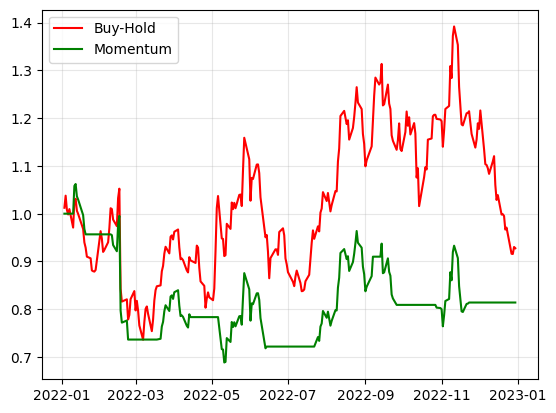

In [ ]:
plt.plot(np.exp(alb['return']).cumprod(), label='Buy-Hold', color= 'red')
plt.plot(np.exp(alb['momentum_return']).cumprod(), label='Momentum', color = 'green')
plt.legend(loc=0)
plt.grid(True, alpha=.3)
plt.show()

In [ ]:
momentum_trading_return_amazon = np.exp(np.sum(amz['momentum_return'])) -1
momentum_trading_return_amazon

-0.2955836370458427

In [ ]:
momentum_trading_return_nike = np.exp(np.sum(nke['momentum_return'])) -1
momentum_trading_return_nike

-0.072914222857825

In [ ]:
momentum_trading_return_albemarle = np.exp(np.sum(alb['momentum_return'])) -1
momentum_trading_return_albemarle

-0.18596387555690697

## 3.3 - Momentum trading strategy for the entire MPT portfolio



In [ ]:
from pandas.core.ops import invalid_comparison
am = 0.885
ni = 0.06
albe = 0.055

inv = 100000
inv_am = am*inv
inv_ni = ni*inv
inv_alb = albe*inv

mt_return = (am*momentum_trading_return_amazon) + (ni*momentum_trading_return_nike) + (albe*momentum_trading_return_albemarle)
mt_return


NameError: ignored

In [ ]:
Total_amount_Momentum = 100000*mt_return + 100000
print('Momentum Trading Strategy Portfolio Value = $',Total_amount_Momentum)

Momentum Trading Strategy Portfolio Value = $ 72380.561468733


## Buy-Hold Return

In [ ]:
bh_return = (am*amz_bh_return) + (ni*nike_bh_return) + (albe*alb_bh_return)
bh_return

-0.46095037581513626

In [ ]:
Total_amount_buyhold = 100000*bh_return + 100000
print('Buy/Hold Trading Strategy Portfolio Value = $',Total_amount_buyhold)

Buy/Hold Trading Strategy Portfolio Value = $ 53904.96241848637


## 3.4    S&P 500 - Index Investing


In [ ]:
ticker = "^GSPC"
sp = si.get_data(ticker,start_date = '01/01/2022',end_date='01/01/2023',interval='1d')
day = np.arange(1, len(sp) + 1) #generate list of trading days
sp['Day'] = day
# Dropping columns I don't want to use
sp.drop(columns=['adjclose', 'volume','ticker'], inplace = True)
# Reorganizing the columns
sp = sp[['Day', 'open', 'high', 'low', 'close']]
sp.head()

,Day,open,high,low,close
2022-01-03,1,4778.140137,4796.640137,4758.169922,4796.560059
2022-01-04,2,4804.509766,4818.620117,4774.270020,4793.540039
2022-01-05,3,4787.990234,4797.700195,4699.439941,4700.580078
2022-01-06,4,4693.390137,4725.009766,4671.259766,4696.049805
2022-01-07,5,4697.660156,4707.950195,4662.740234,4677.029785


In [ ]:
sp['log_close'] = np.log(sp['close'])
sp['return'] = sp['log_close'].diff()


In [ ]:
portfolio = pd.DataFrame()
portfolio['Day'] = amz['Day']
portfolio['return_amz'] = amz['return']
portfolio['momentum_amz'] = amz['momentum_return']
portfolio

,Day,return_amz,momentum_amz
2021-12-31,22,NaN,NaN
2022-01-03,23,0.021877,0.0
2022-01-04,24,-0.017060,-0.0
2022-01-05,25,-0.019074,-0.0
2022-01-06,26,-0.006734,-0.0
...,...,...,...
2022-12-23,269,0.017274,0.0
2022-12-27,270,-0.026266,-0.0
2022-12-28,271,-0.014801,-0.0
2022-12-29,272,0.028436,0.0


In [ ]:
portfolio['return_nke'] = nke['return']
portfolio['momentum_nke'] = nke['momentum_return']
portfolio

,Day,return_amz,momentum_amz,return_nke,momentum_nke
2021-12-31,22,NaN,NaN,NaN,NaN
2022-01-03,23,0.021877,0.0,-0.012072,-0.012072
2022-01-04,24,-0.017060,-0.0,0.010391,0.010391
2022-01-05,25,-0.019074,-0.0,-0.025196,-0.025196
2022-01-06,26,-0.006734,-0.0,-0.007486,-0.007486
...,...,...,...,...,...
2022-12-23,269,0.017274,0.0,-0.003949,-0.003949
2022-12-27,270,-0.026266,-0.0,0.011206,0.011206
2022-12-28,271,-0.014801,-0.0,-0.022191,-0.022191
2022-12-29,272,0.028436,0.0,0.020403,0.020403


In [ ]:
portfolio['return_alb'] = alb['return']
portfolio['momentum_alb'] = alb['momentum_return']
portfolio

,Day,return_amz,momentum_amz,return_nke,momentum_nke,return_alb,momentum_alb
2021-12-31,22,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-03,23,0.021877,0.0,-0.012072,-0.012072,0.012329,0.0
2022-01-04,24,-0.017060,-0.0,0.010391,0.010391,0.024665,0.0
2022-01-05,25,-0.019074,-0.0,-0.025196,-0.025196,-0.029026,-0.0
2022-01-06,26,-0.006734,-0.0,-0.007486,-0.007486,-0.009637,-0.0
...,...,...,...,...,...,...,...
2022-12-23,269,0.017274,0.0,-0.003949,-0.003949,0.004327,0.0
2022-12-27,270,-0.026266,-0.0,0.011206,0.011206,-0.058050,-0.0
2022-12-28,271,-0.014801,-0.0,-0.022191,-0.022191,-0.000561,-0.0
2022-12-29,272,0.028436,0.0,0.020403,0.020403,0.015898,0.0


In [ ]:
portfolio.dropna(inplace=True)


In [ ]:
portfolio

,Day,return_amz,momentum_amz,return_nke,momentum_nke,return_alb,momentum_alb
2022-01-03,23,0.021877,0.0,-0.012072,-0.012072,0.012329,0.0
2022-01-04,24,-0.017060,-0.0,0.010391,0.010391,0.024665,0.0
2022-01-05,25,-0.019074,-0.0,-0.025196,-0.025196,-0.029026,-0.0
2022-01-06,26,-0.006734,-0.0,-0.007486,-0.007486,-0.009637,-0.0
2022-01-07,27,-0.004297,-0.0,-0.025598,-0.025598,0.011249,0.0
...,...,...,...,...,...,...,...
2022-12-23,269,0.017274,0.0,-0.003949,-0.003949,0.004327,0.0
2022-12-27,270,-0.026266,-0.0,0.011206,0.011206,-0.058050,-0.0
2022-12-28,271,-0.014801,-0.0,-0.022191,-0.022191,-0.000561,-0.0
2022-12-29,272,0.028436,0.0,0.020403,0.020403,0.015898,0.0


In [ ]:
portfolio['Date'] = portfolio.index
portfolio

,Day,return_amz,momentum_amz,return_nke,momentum_nke,return_alb,momentum_alb,Date
2022-01-03,23,0.021877,0.0,-0.012072,-0.012072,0.012329,0.0,2022-01-03
2022-01-04,24,-0.017060,-0.0,0.010391,0.010391,0.024665,0.0,2022-01-04
2022-01-05,25,-0.019074,-0.0,-0.025196,-0.025196,-0.029026,-0.0,2022-01-05
2022-01-06,26,-0.006734,-0.0,-0.007486,-0.007486,-0.009637,-0.0,2022-01-06
2022-01-07,27,-0.004297,-0.0,-0.025598,-0.025598,0.011249,0.0,2022-01-07
...,...,...,...,...,...,...,...,...
2022-12-23,269,0.017274,0.0,-0.003949,-0.003949,0.004327,0.0,2022-12-23
2022-12-27,270,-0.026266,-0.0,0.011206,0.011206,-0.058050,-0.0,2022-12-27
2022-12-28,271,-0.014801,-0.0,-0.022191,-0.022191,-0.000561,-0.0,2022-12-28
2022-12-29,272,0.028436,0.0,0.020403,0.020403,0.015898,0.0,2022-12-29


In [ ]:
import datetime as dt
portfolio_bh = portfolio.groupby(portfolio['Date'].dt.month)[['return_amz', 'return_nke', 'return_alb']].sum().cumsum()


In [ ]:
portfolio_bh

,return_amz,return_nke,return_alb
Date,,,
1,-0.108510,-0.118331,-0.057352
2,-0.082187,-0.199325,-0.176784
3,-0.022563,-0.214006,-0.055497
4,-0.293749,-0.290105,-0.192529
5,-0.327062,-0.338154,0.107958
6,-0.450879,-0.489084,-0.112099
7,-0.211393,-0.371780,0.044100
8,-0.273923,-0.448340,0.136500
9,-0.388910,-0.695730,0.123277


In [ ]:
portfolio_bh['Date'] = ["2022-01-03","2022-02-01", "2022-03-01","2022-04-01","2022-05-02", "2022-06-01","2022-07-01","2022-08-01","2022-09-01","2022-10-03", "2022-11-01", "2022-12-01"]

In [ ]:
portfolio_bh['Inv_AMZ'] = (np.exp(portfolio_bh['return_amz']))*inv_am
portfolio_bh['Inv_NKE'] = (np.exp(portfolio_bh['return_nke']))*inv_ni
portfolio_bh['Inv_ALB'] = (np.exp(portfolio_bh['return_alb']))*inv_alb
portfolio_bh['total_investment'] = portfolio_bh['Inv_AMZ']+portfolio_bh['Inv_NKE']+portfolio_bh['Inv_ALB']
portfolio_bh.index.name = None
portfolio_bh[['Date','Inv_AMZ','Inv_NKE','Inv_ALB','total_investment']]

,Date,Inv_AMZ,Inv_NKE,Inv_ALB,total_investment
1,2022-01-03,79399.552946,5330.413714,5193.438029,89923.404689
2,2022-02-01,81517.338972,4915.701850,4608.782038,91041.822859
3,2022-03-01,86525.542961,4844.063084,5203.083989,96572.690035
4,2022-04-01,65973.555311,4489.110157,4536.788256,74999.453724
5,2022-05-02,63811.976791,4278.514422,6127.005380,74217.496593
6,2022-06-01,56380.484218,3679.126348,4916.755595,64976.366161
7,2022-07-01,71636.816107,4137.037239,5747.978620,81521.831966
8,2022-08-01,67294.547186,3832.123290,6304.401446,77431.071922
9,2022-09-01,59984.886278,2992.260287,6221.585263,69198.731827
10,2022-10-03,54379.220325,3336.413319,6584.612846,64300.246491


In [ ]:
portfolio_mt = portfolio.groupby(portfolio['Date'].dt.month)[['momentum_amz', 'momentum_nke', 'momentum_alb']].sum().cumsum()
portfolio_mt['Date'] = ["2022-01-03","2022-02-01", "2022-03-01","2022-04-01","2022-05-02", "2022-06-01","2022-07-01","2022-08-01","2022-09-01","2022-10-03", "2022-11-01", "2022-12-01"]

In [ ]:
portfolio_mt['Inv_AMZ'] = (np.exp(portfolio_mt['momentum_amz']))*inv_am
portfolio_mt['Inv_NKE'] = (np.exp(portfolio_mt['momentum_nke']))*inv_ni
portfolio_mt['Inv_ALB'] = (np.exp(portfolio_mt['momentum_alb']))*inv_alb
portfolio_mt['total_investment'] = portfolio_mt['Inv_AMZ']+portfolio_mt['Inv_NKE']+portfolio_mt['Inv_ALB']
portfolio_mt.index.name = None
portfolio_mt[['Date','Inv_AMZ','Inv_NKE','Inv_ALB','total_investment']]

,Date,Inv_AMZ,Inv_NKE,Inv_ALB,total_investment
1,2022-01-03,88500.000000,5650.807090,5262.038860,99412.845950
2,2022-02-01,84312.724501,5650.807090,4050.632755,94014.164345
3,2022-03-01,85226.171728,5687.154866,4518.751938,95432.078532
4,2022-04-01,79016.851222,4978.297067,4309.109743,88304.258032
5,2022-05-02,79016.851222,4978.297067,4629.257870,88624.406159
6,2022-06-01,65260.311714,4330.041108,3969.941307,73560.294128
7,2022-07-01,75705.997833,4458.056835,4379.555322,84543.609991
8,2022-08-01,77013.112450,4392.109366,4803.510370,86208.732186
9,2022-09-01,77013.112450,4392.109366,4449.916309,85855.138125
10,2022-10-03,65416.447158,4405.895661,4413.644244,74235.987063


In [ ]:
sp['Date'] = sp.index
sp.dropna(inplace=True)
sp


,Day,open,high,low,close,log_close,return,Date
2022-01-04,2,4804.509766,4818.620117,4774.270020,4793.540039,8.475024,-0.000630,2022-01-04
2022-01-05,3,4787.990234,4797.700195,4699.439941,4700.580078,8.455441,-0.019583,2022-01-05
2022-01-06,4,4693.390137,4725.009766,4671.259766,4696.049805,8.454477,-0.000964,2022-01-06
2022-01-07,5,4697.660156,4707.950195,4662.740234,4677.029785,8.450419,-0.004058,2022-01-07
2022-01-10,6,4655.339844,4673.020020,4582.240234,4670.290039,8.448976,-0.001442,2022-01-10
...,...,...,...,...,...,...,...,...
2022-12-23,247,3815.110107,3845.800049,3797.010010,3844.820068,8.254482,0.005851,2022-12-23
2022-12-27,248,3843.340088,3846.649902,3813.219971,3829.250000,8.250424,-0.004058,2022-12-27
2022-12-28,249,3829.560059,3848.320068,3780.780029,3783.219971,8.238331,-0.012093,2022-12-28
2022-12-29,250,3805.449951,3858.189941,3805.449951,3849.280029,8.255641,0.017311,2022-12-29


In [ ]:
sp500 = sp.groupby(sp['Date'].dt.month)[['return']].sum().cumsum()

In [ ]:
sp500['Date'] = ["2022-01-03","2022-02-01", "2022-03-01","2022-04-01","2022-05-02", "2022-06-01","2022-07-01","2022-08-01","2022-09-01","2022-10-03", "2022-11-01", "2022-12-01"]

In [ ]:
sp500.index.name = None

In [ ]:
sp500[['Date', 'return']]

,Date,return
1,2022-01-03,-0.060372
2,2022-02-01,-0.092235
3,2022-03-01,-0.057087
4,2022-04-01,-0.149154
5,2022-05-02,-0.149101
6,2022-06-01,-0.236753
7,2022-07-01,-0.149551
8,2022-08-01,-0.192918
9,2022-09-01,-0.290968
10,2022-10-03,-0.214133


In [ ]:
report = pd.DataFrame()
report['Date'] = sp500['Date']
report['Buy-Hold'] = portfolio_bh['total_investment']
report['Momentum Trading'] = portfolio_mt['total_investment']
report['SP500'] = (1+sp500['return'])*100000
report

,Date,Buy-Hold,Momentum Trading,SP500
1,2022-01-03,89923.404689,99412.845950,93962.794583
2,2022-02-01,91041.822859,94014.164345,90776.518481
3,2022-03-01,96572.690035,95432.078532,94291.347108
4,2022-04-01,74999.453724,88304.258032,85084.564617
5,2022-05-02,74217.496593,88624.406159,85089.882246
6,2022-06-01,64976.366161,73560.294128,76324.724066
7,2022-07-01,81521.831966,84543.609991,85044.862535
8,2022-08-01,77431.071922,86208.732186,80708.159468
9,2022-09-01,69198.731827,85855.138125,70903.242806
10,2022-10-03,64300.246491,74235.987063,78586.699253


In [ ]:
total_amount_index = ((1+sp500.loc[12,'return'])*100000)
total_amount_index

77744.3143253814

##3.5 - Plot Comparing the Investment Strategies

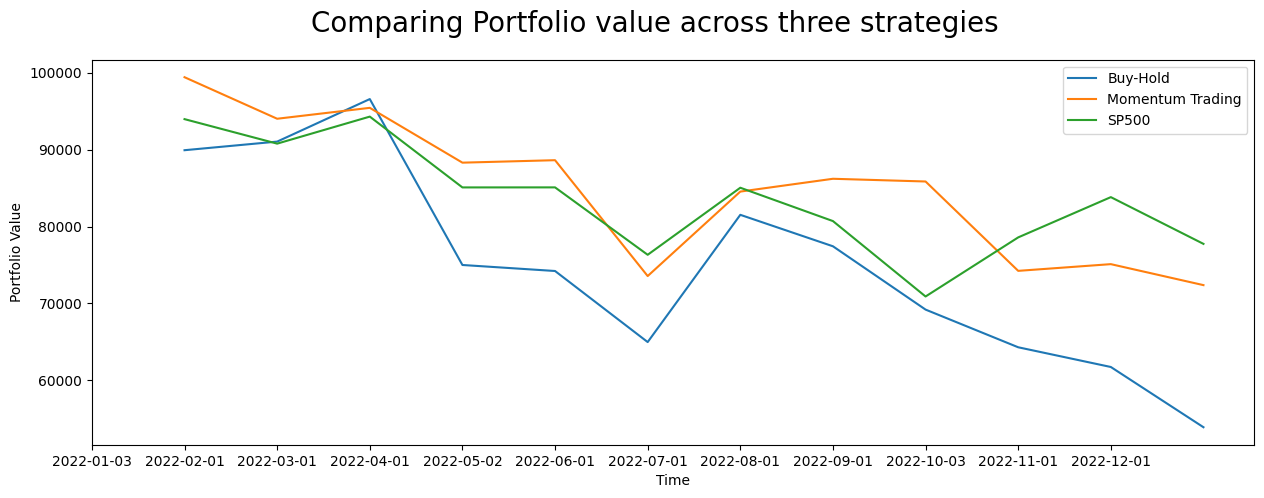

In [ ]:
fig,ax = plt.subplots(figsize=(15,5))
report.iloc[:,1:4].plot(ax = ax)
ax.set_xlabel('Time')
ax.set_ylabel('Portfolio Value')
fig.suptitle("Comparing Portfolio value across three strategies", fontsize=20)
x_vals = range(0, len(report['Date']))
plt.xticks(x_vals, report['Date'].to_list())
#ax.set_xticklabels(graph['Date'].to_list(), rotation=0)
plt.show()

In [ ]:
print('Buy/Hold Trading Strategy Portfolio Value = $',Total_amount_buyhold)
print('Momentum Trading Strategy Portfolio Value = $',Total_amount_Momentum)
print('S&P500 Trading Strategy Portfolio Value = $',total_amount_index)

Buy/Hold Trading Strategy Portfolio Value = $ 53904.96241848637
Momentum Trading Strategy Portfolio Value = $ 72380.561468733
S&P500 Trading Strategy Portfolio Value = $ 77744.3143253814


# 4 - Conclusion

## 4.1 - Thoughts and Insights

- We can take away from this exercise is the impact of global, economic, and political events on the performance of individual stocks and the market as a whole. The COVID-19 pandemic, for example, had a significant impact on the stock market in 2020, causing many companies' stocks to plummet while others surged. By analyzing the performance of different stocks and portfolios during this time period, we can see firsthand how unexpected events can lead to dramatic changes in the market and underscore the importance of diversification and risk management in investing.
- Our analysis using Modern Portfolio Theory and Momentum Trading showed that it is possible to create a portfolio of stocks that balances risk and profit appropriately.
- Our portfolio selection process using the Modern Portfolio Theory (MPT) helped us identify a diversified portfolio of three stocks (AMZN, NKE, and ALB) with optimal risk and return characteristics. By allocating weights of 88.5% to AMZN, 6% to NKE, and 5.5% to ALB, we were able to achieve a balanced portfolio with an expected return of 0.00061 and a risk of 0.00030.
- Additionally, by implementing the MT strategy, we were able to further increase our portfolio value by capitalizing on short-term trends in the stock prices.
- The Buy/Hold strategy resulted in a negative return, indicating that holding onto the stocks for the entire period did not provide a profitable outcome. This suggests that a passive investment approach may not always be the best option and that active trading strategies such as momentum trading may provide better returns in certain market conditions. However, it is important to note that past performance does not guarantee future results and that any investment decision should be made after considering various factors such as risk tolerance, investment horizon, and market trends.
- After implementing and evaluating three different trading strategies, we found that the S&P500 Trading Strategy was the most effective, resulting in a portfolio value of 77,744.31. The Momentum Trading Strtegy also performed well, with a final portfolio value of 72,380.56. However, the Buy/Hold Trading Strategy was the least successful, with a final portfolio value of 53,904.96.It's important to note that these results are based on a historical analysis and may not necessarily reflect future performance. Additionally, the strategies and parameters used may not be optimal and could be further optimized through additional testing and analysis.